In [1]:
%%capture
!pip install -U spacy
!python -m spacy download de_core_news_lg
!pip install xlsxwriter

In [2]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, GRU, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D, Conv1D,concatenate,Concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import statistics
from statistics import mean, stdev
import spacy
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import xlsxwriter
from keras.initializers import Constant
from gensim.models import KeyedVectors
import random
import xlsxwriter
import sklearn as sk
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

#Setup

In [3]:
###############  Hyperparameter definieren   ######################
randomstate = 41
#Textaufbereitung
vocab_size = 10000
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#Cross Validation
splits = 10
kfold = StratifiedKFold(n_splits=splits,shuffle=True, random_state=randomstate)

#Modell
embedding_dim = 300
batch_size = 20
no_epochs = 10
verbosity = 1

class_names = ['A1','A2','B1','B2','C']

##Funktionen

In [4]:
def convert_to_one_hot(_fitdata,_transformdata):
  from sklearn.preprocessing import LabelEncoder
  from keras.utils import np_utils
  #Lable in Zahlen umwandeln
  encoder = LabelEncoder()
  encoder.fit(_fitdata)
  encoded_data = encoder.transform(_transformdata)
  #Zahlen in One Hot Vektoren umwandeln
  one_hot_vectors = np_utils.to_categorical(encoded_data)
  return [one_hot_vectors,encoder]

def convert_to_int(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {'A1': 1,'A2': 2,'B1': 3,'B2':4,'C':5}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return [label_sequence, label_tokenizer]

def convert_to_label(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {1: 'A1', 2: 'A2',3: 'B1',4:'B2',5:'C'}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return label_sequence

def model_evaluation_classification(_x_test, _y_test, _encoder):
  y_pred = model.predict(_x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=['A1','A2','B1','B2','C'])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def model_evaluation_regression(_x_test, _y_test):
  y_pred = model.predict(_x_test)
  y_pred = np.clip(np.rint(y_pred), 0, 5)
  #y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Richtige Niveaustufe')
    plt.xlabel('Vorhergesagte Niveaustufe')

    return cnf_matrix

################# Funktion zum Trainieren und evaluieren #####################
def evaluate_model(_input=None, _target=None, _approach='klassisch_re'):
  _approaches = ['klassisch_cl','klassisch_re', 'knn']
  if _approach not in _approaches:
    raise ValueError("Invalid sim type. Expected one of: %s" % _approach)

  predicted_targets = np.array([])
  true_targets = np.array([])
  acc_per_fold = []
  kappa_per_fold = []
  for train, test in kfold.split(_input, _target):   
    x_train = _input[train]
    x_test = _input[test]
    y_train = _target[train]
    y_test = _target[test]

    if _approach == 'klassisch_cl' or _approach == 'klassisch_re':
      model = svm
      y_train = np.where(y_train=='A1', 1.0, y_train)
      y_train = np.where(y_train=='A2', 2.0, y_train)
      y_train = np.where(y_train=='B1', 3.0, y_train)
      y_train = np.where(y_train=='B2', 4.0, y_train)
      y_train = np.where(y_train=='C', 5.0, y_train)

    if _approach == 'knn':
      model = normal_knn_model()

    if _approach == 'knn':
      #Zielvariablen in One Hot Repräsentation umwandeln
      one_hot = convert_to_one_hot(_target,y_train)
      encoder = one_hot[1]
      y_train = one_hot[0]
    
    #Modell trainieren
    if _approach == 'knn':
      model.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)
      
    elif _approach == 'klassisch_cl' or _approach == 'klassisch_re':
      model.fit(x_train,y_train)


    #Vorhersagen treffen
    predicted_labels = model.predict(x_test)

    if _approach == 'knn':
      #One Hot wieder in Labels umwandeln
      predicted_labels = np.argmax(predicted_labels, axis=1)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    elif _approach == 'klassisch_re':
      predicted_labels = np.clip(np.rint(predicted_labels),0,5)
      predicted_labels = np.where(predicted_labels==1.0, 'A1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='2.0', 'A2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='3.0', 'B1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='4.0', 'B2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='5.0', 'C', predicted_labels)
    elif _approach == 'klassisch_cl':
      #predicted_labels = np.clip(np.rint(predicted_labels),0,5)
      predicted_labels = np.where(predicted_labels=='1.0', 'A1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='2.0', 'A2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='3.0', 'B1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='4.0', 'B2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='5.0', 'C', predicted_labels)

    predicted_targets= np.append(predicted_targets, predicted_labels)
    true_targets = np.append(true_targets, y_test)

    #Metriken berechnen


    kappa = cohen_kappa_score(y_test,predicted_labels,weights='quadratic')  
    acc = accuracy_score(y_test,predicted_labels)*100
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
  acc = mean(acc_per_fold)
  kappa = mean(kappa_per_fold)
  return predicted_targets, true_targets, acc, kappa



#Labeles aufbereiten

In [5]:
labels = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/metadaten.xlsx', index_col=0)


In [6]:
labels.sort_values(by=['id'],inplace=True)


In [7]:
labels.cerf_rating.replace(['A2','A2+'],'A2', inplace=True)
labels.cerf_rating.replace(['B1','B1+'],'B1', inplace=True)
labels.cerf_rating.replace(['B2','B2+'],'B2', inplace=True)
labels.cerf_rating.replace(['C1','C2'],'C', inplace=True)

In [8]:
l_labels = labels['cerf_rating'].to_list()


In [9]:
################ Labels aufbereiten #########################
target = np.array(l_labels)

#Feature aufbereiten

In [10]:
data = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/features.xlsx', index_col=0)  

In [11]:
all_features = data.drop(columns=['cerf_rating','lex_ttr','lex_verb_var_1','lex_sqrt_verb_var_1','lex_cor_verb_var_1','lex_wiener_sachtextformel','morph_first_person_fin_verb_ratio'])

In [12]:
#Featureset mit niedriger korrelation (-0.5 >= r <= 0.5) erstellen
corr = all_features.drop(columns=['shal_text_length']).corrwith(all_features['shal_text_length'],axis=0,method='pearson',)

low_corr = []
for index in corr.index:
  if corr[index] >= -0.5 and corr[index] <= 0.5:
    low_corr.append(index)

low_corr_features = all_features[low_corr]

In [13]:
low_corr_features

,lex_hdd,lex_mtld,lex_adverb_var,lex_modifier_var,lex_noun_var,lex_verb_var_2,er_avg_num_errors,dep_per_noun,dep_per_verb,syn_avg_len_clause,syn_avg_nonterminals_per_sent,syn_avg_tunit_length,syn_avg_vz_per_sent,syn_avg_corinate_phrases_per_sent,lex_yules_k,lex_uber_index,shal_chars_per_word,shal_syl_per_word,morph_comp_noun_ratio,morph_first_person_verb_ratio,morph_second_person_verb_ratio,morph_third_person_verb_ratio,morph_past_tense_verb_ratio,morph_past_participle_verb_ratio,morph_nominative_nouns_ratio,morph_genitiv_nouns_ratio,morph_dativ_nouns_ratio,morph_akkusativ_nouns_ratio,morph_singular_nouns_ratio,morph_plural_nouns_ratio,morph_keit_suffix_ratio,morph_ung_suffix_ratio,morph_werk_suffix_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1023_0001416,0.783363,43.956186,0.071429,0.261905,0.428571,0.238095,0.722222,1.375000,2.923077,6.3600,21.4000,8.8333,0.2000,0.3333,93.6884,86.0749,5.913043,1.950311,0.325000,1.038462,0.000000,0.423077,0.961538,0.153846,0.350000,0.025000,0.275000,0.350000,1.975000,0.725000,0.050000,0.100000,0.0
1023_0001418,0.800869,53.645573,0.054795,0.164384,0.410959,0.301370,1.150000,1.281250,2.555556,7.2174,19.9375,8.7368,0.0000,0.3750,106.3355,71.5175,5.708333,1.934524,0.156250,0.900000,0.000000,0.400000,0.833333,0.100000,0.281250,0.031250,0.156250,0.500000,2.625000,0.937500,0.000000,0.062500,0.0
1023_0001419,0.806800,57.793976,0.064935,0.246753,0.350649,0.298701,0.937500,1.222222,2.333333,7.3636,24.6923,8.5263,1.0000,0.3077,93.3606,83.0995,5.926380,1.975460,0.296296,0.812500,0.000000,0.375000,0.750000,0.000000,0.148148,0.000000,0.259259,0.592593,2.629630,1.111111,0.000000,0.111111,0.0
1023_0001420,0.788381,47.501553,0.095890,0.178082,0.397260,0.342466,0.944444,0.969697,2.826087,6.5357,25.0000,8.3182,0.3333,0.2857,122.0964,61.9366,5.572973,1.864865,0.303030,1.088235,0.000000,0.382353,0.911765,0.058824,0.242424,0.030303,0.242424,0.454545,2.606061,0.909091,0.030303,0.060606,0.0
1023_0001422,0.854652,74.659968,0.083333,0.142857,0.488095,0.226190,0.978723,1.021277,2.733333,9.5238,30.4615,12.5000,0.0000,0.3077,90.8071,73.0191,5.477833,1.793103,0.255319,0.833333,0.000000,0.333333,0.916667,0.000000,0.425532,0.021277,0.255319,0.319149,2.468085,0.404255,0.000000,0.021277,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091_0000272,0.757471,43.440156,0.034483,0.103448,0.275862,0.310345,0.846154,1.090909,2.666667,4.5385,11.6364,4.9167,0.0000,0.0000,86.1821,66.8002,4.793651,1.523810,0.636364,0.538462,0.230769,0.615385,0.769231,0.076923,0.454545,0.090909,0.181818,0.363636,3.727273,0.090909,0.000000,0.000000,0.0
1091_0000273,0.797920,77.000000,0.230769,0.230769,0.346154,0.384615,0.444444,1.416667,2.666667,5.9091,15.6250,7.2222,0.0000,0.0000,141.0935,63.1241,4.776119,1.537313,0.333333,0.785714,0.357143,0.285714,0.928571,0.071429,0.250000,0.000000,0.333333,0.416667,3.750000,0.000000,0.000000,0.000000,0.0
1091_0000274,0.768549,42.117647,0.000000,0.055556,0.333333,0.361111,1.214286,1.214286,2.600000,4.7059,14.8333,5.3333,0.0000,0.0833,140.6250,59.7112,4.523810,1.547619,0.428571,1.000000,0.157895,0.368421,0.789474,0.105263,0.357143,0.000000,0.142857,0.571429,4.214286,0.214286,0.000000,0.000000,0.0


In [14]:
all_features = all_features.drop(columns=['shal_text_length'])

In [15]:
print(len(low_corr_features.columns))
print(len(all_features.columns))

33
43


In [16]:
#Features normalisieren [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
input_low_corr = scaler.fit_transform(low_corr_features)
input_all = scaler.fit_transform(all_features)


In [17]:
input_low_corr.shape
input_all.shape

(1033, 43)

#Training Low_corr

Confusion matrix, without normalization


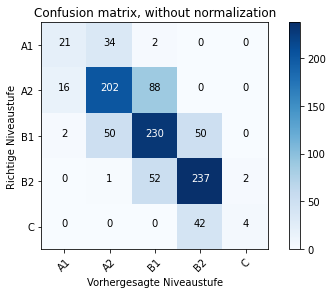

Normalized confusion matrix


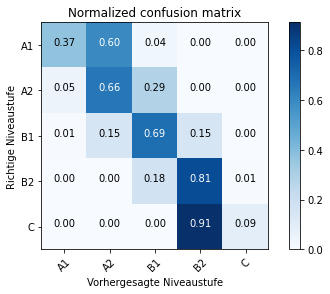

In [18]:
##### klassischer Ansatz SVR
svm = SVR()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_low_corr, target,'klassisch_re')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

svr = {'name': 'svr',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


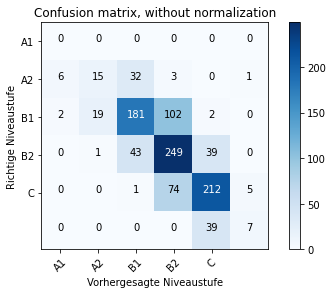

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix


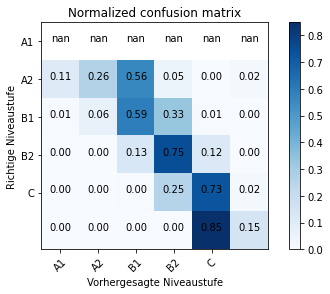

In [19]:
##### klassischer Ansatz lin. Re
svm = LinearRegression()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_low_corr, target,'klassisch_re')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

linre = {'name': 'lin. Re',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


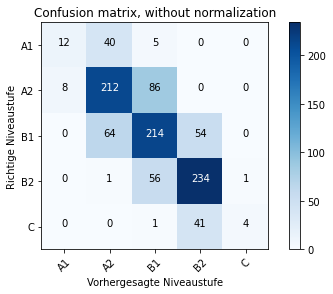

Normalized confusion matrix


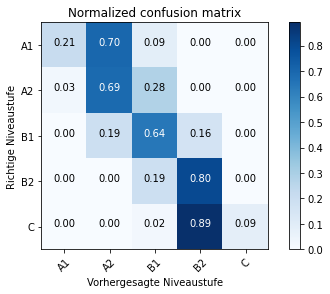

In [20]:
##### klassischer Ansatz RFR
svm = RandomForestRegressor(random_state=randomstate)

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_low_corr, target,'klassisch_re')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

rfr = {'name': 'rfr',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


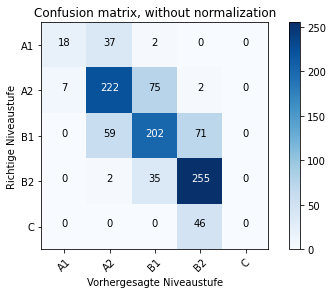

Normalized confusion matrix


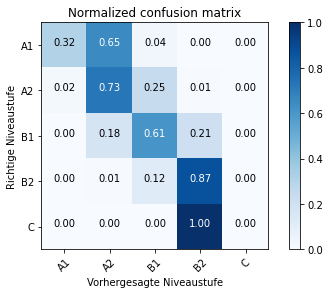

In [21]:
##### klassischer Ansatz SVC
svm = SVC()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_low_corr, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

svc = {'name': 'svc',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Confusion matrix, without normalization


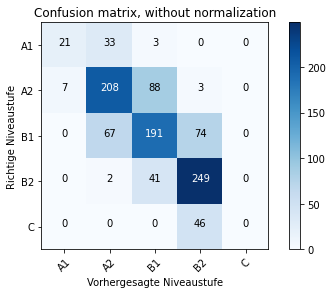

Normalized confusion matrix


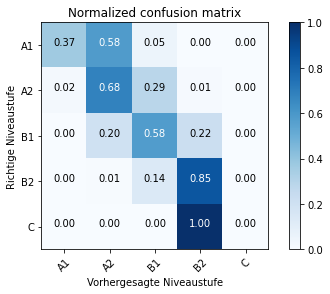

In [22]:
##### klassischer Ansatz log Re
svm = LogisticRegression()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_low_corr, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

logre = {'name': 'log. Re',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


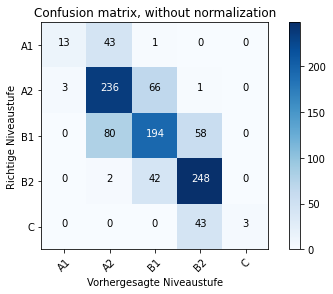

Normalized confusion matrix


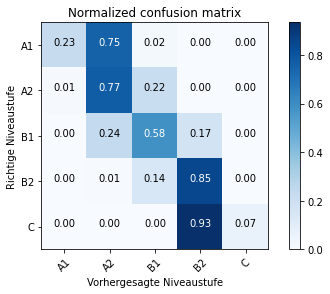

In [23]:
##### klassischer Ansatz RFK
svm = RandomForestClassifier(random_state=randomstate)

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_low_corr, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

rfk = {'name': 'rfk',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

In [24]:
results = pd.DataFrame([svc,svr,linre,logre,rfk,rfr] ,columns=['name','acc','qwk'])
results.sort_values('qwk')

,name,acc,qwk
2,lin. Re,64.272778,0.773192
3,log. Re,64.765683,0.783965
5,rfr,65.440627,0.784798
1,svr,67.174197,0.802925
0,svc,67.468260,0.803174
4,rfk,67.179798,0.803959


In [25]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/best_model_klassisch_low_corr.xlsx', engine='xlsxwriter', index=False)  

#Training all Features

Confusion matrix, without normalization


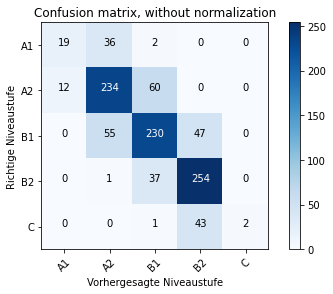

Normalized confusion matrix


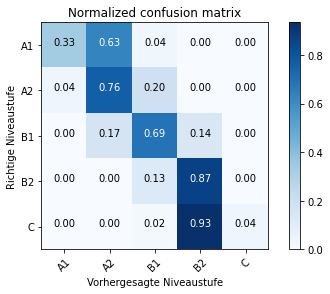

In [18]:
##### klassischer Ansatz SVR
svm = SVR()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_all, target,'klassisch_re')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

svr = {'name': 'svr',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


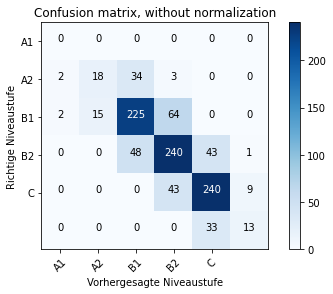

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix


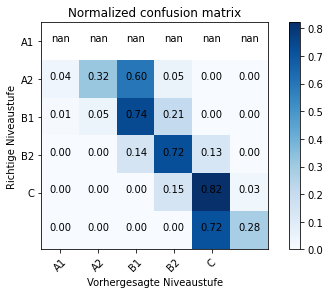

In [27]:
##### klassischer Ansatz lin. Re
svm = LinearRegression()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_all, target,'klassisch_re')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

linre = {'name': 'lin. Re',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


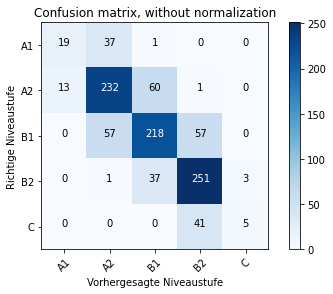

Normalized confusion matrix


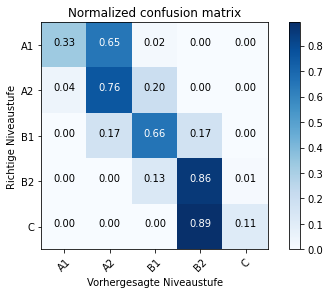

In [28]:
##### klassischer Ansatz RFR
svm = RandomForestRegressor(random_state=randomstate)

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_all, target,'klassisch_re')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

rfr = {'name': 'rfr',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


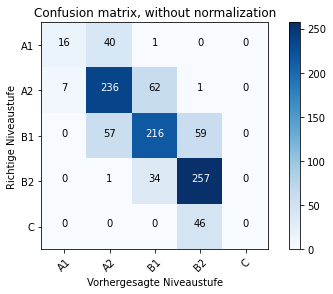

Normalized confusion matrix


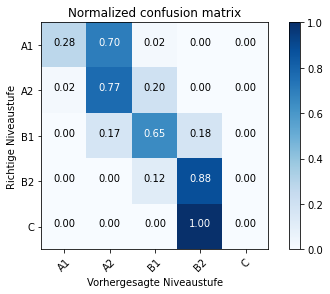

In [29]:
##### klassischer Ansatz SVC
svm = SVC()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_all, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

svc = {'name': 'svc',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Confusion matrix, without normalization


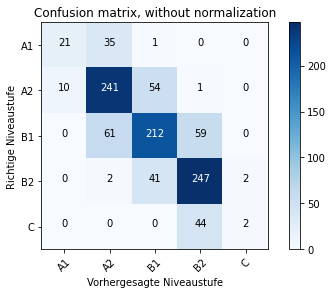

Normalized confusion matrix


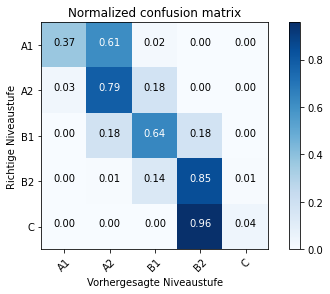

In [30]:
##### klassischer Ansatz log Re
svm = LogisticRegression()

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_all, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

logre = {'name': 'log. Re',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

Confusion matrix, without normalization


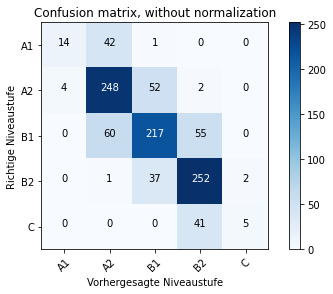

Normalized confusion matrix


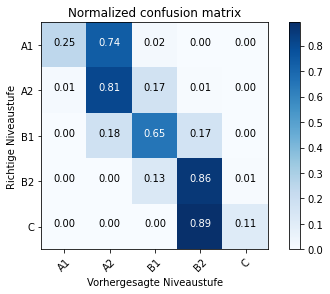

In [31]:
##### klassischer Ansatz RFK
svm = RandomForestClassifier(random_state=randomstate)

great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_all, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

rfk = {'name': 'rfk',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

In [32]:
results = pd.DataFrame([svc,svr,linre,logre,rfk,rfr] ,columns=['name','acc','qwk'])
results.sort_values('qwk')

,name,acc,qwk
0,svc,70.178305,0.822714
3,log. Re,69.985997,0.823729
5,rfr,70.181105,0.827636
4,rfk,71.248133,0.828446
1,svr,71.531927,0.829386
2,lin. Re,71.237864,0.832728


In [33]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/best_model_klassisch_all_features.xlsx', engine='xlsxwriter', index=False)  